# Energy A.I. Hackathon 2024 Workflow - [Energpt] 

#### Authors: 
#### 1. Ahmed Merzoug,  Hildebrand Austin Department of Petroleum and Geosystems Engineering
#### 2. Lie Liu,  Hildebrand Austin Department of Petroleum and Geosystems Engineering
#### 3. Mohamed Awad,  Hildebrand Austin Department of Petroleum and Geosystems Engineering
#### 4. Erica Orona,  McCombs School of Business 

#### The University of Texas at Austin, Austin, Texas, USA 
___

### Executive Summary 

To predict the "average pump difference" crucial for hydraulic fracturing operations, our team followed a process involving data cleaning, feature selection, building and fine-tuning machine learning models, and applying bootstrap methods for uncertainty analysis. We learned the importance of combining data analytics with domain expertise due to the complex nature of real-world data. Moving forward, we recommend a time-series approach for crucial variables and creating a pressure gradient map to enhance prediction accuracy and aid in optimal fluid selection, streamlining the planning and execution of hydraulic fracturing operations.
___

### Workflow Goal

The primary goal is to accurately predict the "average pump difference"  accounting for uncertainty, to prevent fluid loss and optimize fluid system selection. This is achieved through a meticulous process involving data cleaning, feature selection, machine learning model development and fine-tuning, and bootstrap methods for uncertainty analysis, directly influencing the planning, scheduling, and budgeting of these operations.
___

### Workflow Steps 

Enumerated steps, very short and concise overview of your methods and workflow

1. **Data Analysis and Cleaning** - basic data checking and visualization
2. **Feature Selection** - Correlation analysis, mutual information-based approach with minimum redundancy, maximum relevance score
3. **Machine Learning Model \#1** - Predict feature Average Pump Difference 
from Pressure Gradient, Fluid System, Avg Close Pressure, Lateral Length, Area and PARENT_3000_WELL_COUNT
4. **Uncertainty Model** 



### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np                                                                     # ndarrys for gridded data
import pandas as pd                                                                    # DataFrames for tabular data
import os                                                                              # set working directory, run executables
import matplotlib.pyplot as plt                                                        # for plotting
from matplotlib.colors import ListedColormap                                           # custom color maps
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)                      # control of axes ticks
from scipy import stats                                                                # summary statistics
import math                                                                            # trigonometry etc.
import scipy.signal as signal                                                          # kernel for moving window calculation
import random                                                                          # for randon numbers
import seaborn as sns                                                                  # for matrix scatter plots
from scipy import linalg                                                               # for linear regression
from sklearn import preprocessing                                                      # remove encoding error
from sklearn.feature_selection import RFE                                              # for recursive feature selection
from sklearn.feature_selection import mutual_info_regression                           # mutual information
from sklearn.linear_model import LinearRegression                                      # linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
#from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score


### Load Data

The following workflow applies the .csv file 'HackathonData2024.csv'. The dataset was provided by 4th ANNUAL ENERGY A.I. HACKATHON hosts 

In [8]:
os.chdir('/Users/ericaorona/Desktop/hackathon')  # set the working directory
#os.chdir(cwd)
data = pd.read_csv("HackathonData2024.csv")   

In [3]:
cwd = os.getcwd()

'/Users/ericaorona/Desktop/hackathon'

In [9]:
data.isnull()

,Well ID,Avg Pump Difference,Area,Lateral Length,Fluid System,TVD,Development Strategy,DELAYED,BOUND_CODE,CODEV_POSITION,...,CODEV_3000_AVG_TVD_DIST,CODEV_3000_AVG_WELL_AGE,CODEV_3000_MEDIAN_WELL_AGE,CODEV_3000_WELL_COUNT,Pressure Gradient (psi/ft) new,Soak Time,Avg Open Pressure,SD Open Pressure,Avg Close Pressure,SD Close Pressure
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
344,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
345,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
346,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Basic Data Checking and Visulaization 

* we check the provided data to have an idea which fetaures have missing information that we may not use for building the model


In [3]:
def plot_corr(dataframe,size=10):                       # plots a correlation matrix as a heat map 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

### Data Cleaning: 1st round feature selection

In [69]:
# remove outliers and Nan rows of some specific features

# if df is your current dataframe
df = data[['Well ID','Avg Pump Difference','Area','Lateral Length','TVD','Fluid System','Development Strategy','DELAYED','BOUND_CODE',
                   'PARENT_CODEV_1050_WELL_COUNT','PARENT_3000_AVG_HYPOT_DIST','PARENT_3000_AVG_WELL_AGE','PARENT_3000_WELL_COUNT',
                   'CODEV_3000_AVG_HYPOT_DIST','CODEV_3000_AVG_WELL_AGE',
             'CODEV_3000_WELL_COUNT','CODEV_1050_WELL_COUNT','Pressure Gradient (psi/ft) new','Soak Time','Avg Close Pressure']]

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well ID,348.0,1.800345e+02,1.031601e+02,1.000000,9.150000e+01,1.805000e+02,2.692500e+02,3.560000e+02
Avg Pump Difference,333.0,2.246405e+01,2.432724e+01,-12.690000,3.860000e+00,1.737000e+01,3.433000e+01,1.172600e+02
Lateral Length,348.0,1.111523e+04,2.408755e+03,2300.000000,1.000000e+04,1.030000e+04,1.270000e+04,1.820000e+04
TVD,344.0,9.082369e+03,8.542595e+02,7345.000000,8.340000e+03,8.912500e+03,9.968750e+03,1.067500e+04
DELAYED,348.0,7.183908e-01,4.504314e-01,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
BOUND_CODE,348.0,9.893037e+06,2.814065e+06,1110.000000,1.000100e+07,1.101100e+07,1.111100e+07,1.111111e+07
PARENT_CODEV_1050_WELL_COUNT,348.0,3.218391e+00,2.062009e+00,0.000000,2.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
PARENT_3000_AVG_HYPOT_DIST,321.0,2.175642e+03,3.326649e+02,1482.000000,1.910000e+03,2.141000e+03,2.464000e+03,2.971000e+03
PARENT_3000_AVG_WELL_AGE,321.0,2.393019e+03,1.323785e+03,258.000000,1.366000e+03,2.109000e+03,3.242000e+03,5.907000e+03
PARENT_3000_WELL_COUNT,348.0,1.384483e+01,1.014472e+01,0.000000,7.000000e+00,1.200000e+01,2.000000e+01,4.700000e+01


In [70]:
# encode the categorical columns
newdf = df.dropna(subset=['Fluid System','Area',])
newdf.describe().transpose()

categorical_columns = ['Area','Fluid System','Development Strategy']

for col in categorical_columns:
    newdf[col] = pd.Categorical(newdf[col]).codes

newdf.describe().transpose()

C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\2795146017.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf[col] = pd.Categorical(newdf[col]).codes


,count,mean,std,min,25%,50%,75%,max
Well ID,337.0,1.745668e+02,1.001961e+02,1.000000,8.800000e+01,1.750000e+02,2.610000e+02,3.530000e+02
Avg Pump Difference,322.0,2.189239e+01,2.393216e+01,-12.690000,3.570000e+00,1.683500e+01,3.375750e+01,1.172600e+02
Area,337.0,1.314243e+01,7.992773e+00,0.000000,7.000000e+00,1.300000e+01,2.000000e+01,3.000000e+01
Lateral Length,337.0,1.110148e+04,2.399398e+03,2300.000000,1.000000e+04,1.030000e+04,1.270000e+04,1.820000e+04
TVD,333.0,9.083078e+03,8.522878e+02,7345.000000,8.340000e+03,8.915000e+03,9.965000e+03,1.067500e+04
Fluid System,337.0,4.955490e-01,6.414347e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
Development Strategy,337.0,1.786350e+00,1.446071e+00,0.000000,0.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
DELAYED,337.0,7.181009e-01,4.505935e-01,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
BOUND_CODE,337.0,9.865034e+06,2.854196e+06,1110.000000,1.000100e+07,1.101100e+07,1.111100e+07,1.111111e+07
PARENT_CODEV_1050_WELL_COUNT,337.0,3.213650e+00,2.079246e+00,0.000000,2.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01


* since parent_3000_avg_hypot_dist and parent_3000_avg_well_age both have many missing samples, so we don't consider them

In [71]:
# dealing with missing data
newdf2 = newdf.dropna(subset=['PARENT_3000_AVG_HYPOT_DIST','PARENT_3000_AVG_WELL_AGE'])
newdf2.describe().transpose()

newdf3 = newdf2.dropna(subset=['Pressure Gradient (psi/ft) new','Avg Close Pressure'])
newdf3.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well ID,307.0,1.722638e+02,9.890974e+01,1.000000,8.500000e+01,1.750000e+02,2.555000e+02,3.530000e+02
Avg Pump Difference,293.0,2.264297e+01,2.415849e+01,-12.690000,4.130000e+00,1.809000e+01,3.377000e+01,1.172600e+02
Area,307.0,1.300000e+01,7.893904e+00,0.000000,5.500000e+00,1.300000e+01,1.900000e+01,3.000000e+01
Lateral Length,307.0,1.106775e+04,2.333761e+03,7300.000000,9.950000e+03,1.030000e+04,1.260000e+04,1.820000e+04
TVD,303.0,9.111122e+03,8.771658e+02,7345.000000,8.335000e+03,8.920000e+03,1.008000e+04,1.067500e+04
Fluid System,307.0,5.048860e-01,6.536541e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
Development Strategy,307.0,1.716612e+00,1.488897e+00,0.000000,0.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
DELAYED,307.0,7.785016e-01,4.159331e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
BOUND_CODE,307.0,1.014020e+07,2.397550e+06,1110.000000,1.000101e+07,1.101110e+07,1.111100e+07,1.111111e+07
PARENT_CODEV_1050_WELL_COUNT,307.0,3.140065e+00,2.112039e+00,0.000000,2.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01


We are deviding the data into training and testing data 

In [72]:
# divide to trianing and testing data (the data we need to predict)
training = newdf3.dropna(subset=['Avg Pump Difference'])

testing = newdf3.loc[newdf3['Avg Pump Difference'].isnull()]

Checking the testing data 

In [73]:
# check testing data (supposed to be 15 samples)
testing.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well ID,14.0,1.556429e+02,109.024067,4.000000e+00,7.225000e+01,1.340000e+02,2.320000e+02,3.450000e+02
Avg Pump Difference,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Area,14.0,8.785714e+00,7.094728,0.000000e+00,2.250000e+00,8.500000e+00,1.375000e+01,2.000000e+01
Lateral Length,14.0,1.081429e+04,2469.150319,7.300000e+03,9.925000e+03,1.015000e+04,1.097500e+04,1.580000e+04
TVD,14.0,8.847143e+03,790.167252,8.160000e+03,8.203750e+03,8.812500e+03,8.918750e+03,1.055500e+04
Fluid System,14.0,6.428571e-01,0.744946,0.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00,2.000000e+00
Development Strategy,14.0,1.500000e+00,1.400549,0.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
DELAYED,14.0,8.571429e-01,0.363137,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
BOUND_CODE,14.0,1.055660e+07,561548.063015,1.000100e+07,1.000100e+07,1.056100e+07,1.111078e+07,1.111110e+07
PARENT_CODEV_1050_WELL_COUNT,14.0,3.357143e+00,2.706321,0.000000e+00,2.000000e+00,2.500000e+00,4.000000e+00,1.100000e+01


#### check trainig data feature distribution


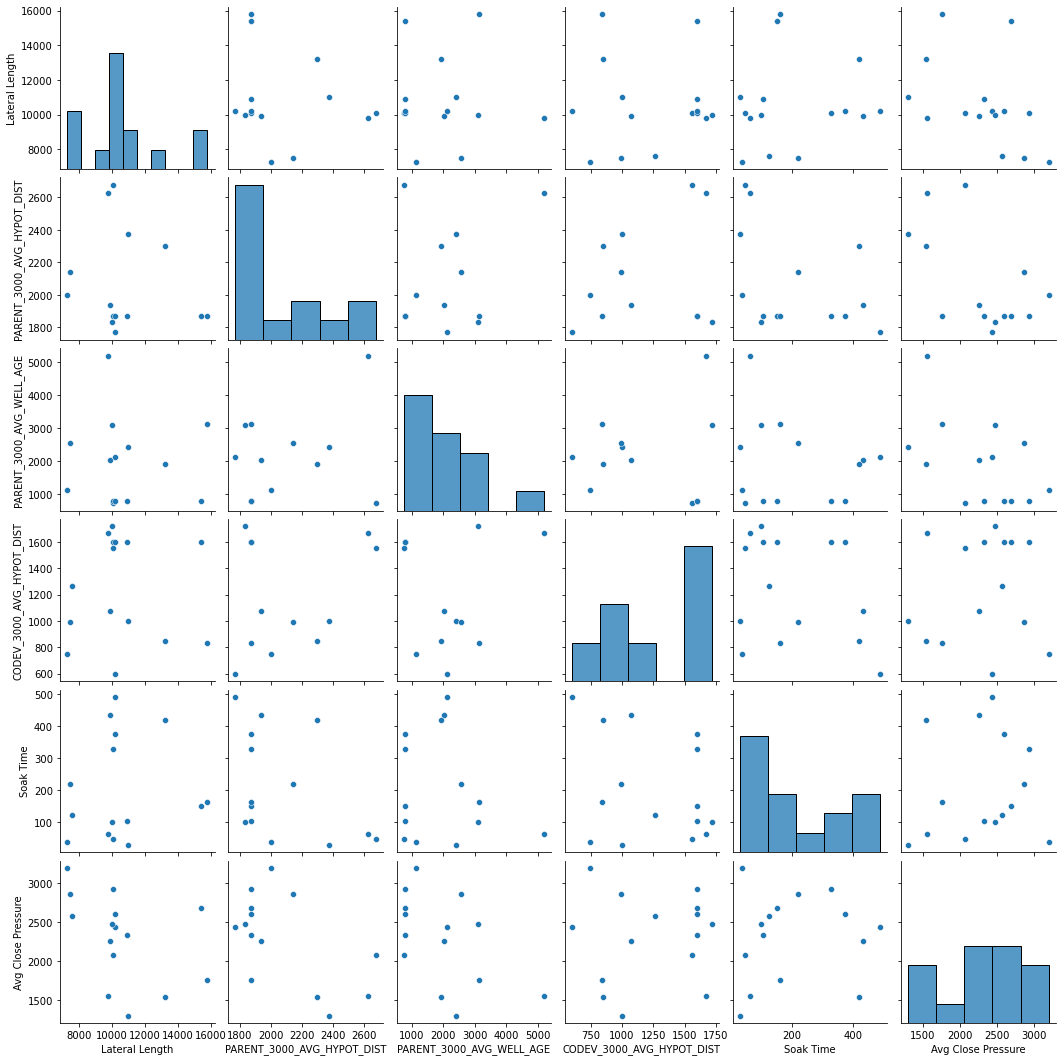

In [9]:
sns.pairplot(testing[['Lateral Length','PARENT_3000_AVG_HYPOT_DIST','PARENT_3000_AVG_WELL_AGE','CODEV_3000_AVG_HYPOT_DIST','Soak Time','Avg Close Pressure']])

Remove the outlier of lateral length

In [49]:
index_of_min = training['Lateral Length'].idxmin() 
newdf2 = training.drop(index_of_min)

Drop columns have many missing samples

In [50]:
# now filter the NaN rows of 'Pressure Gradient (psi/ft) new','TVD'
newdf4 = newdf2.dropna(subset=['Pressure Gradient (psi/ft) new','TVD'])
newdf4.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well ID,314.0,1.775159e+02,9.938103e+01,1.000000,9.550000e+01,1.785000e+02,2.637500e+02,3.530000e+02
Avg Pump Difference,314.0,2.227780e+01,2.406471e+01,-12.690000,3.677500e+00,1.759500e+01,3.419750e+01,1.172600e+02
Area,314.0,1.337261e+01,8.015840e+00,0.000000,7.000000e+00,1.300000e+01,2.000000e+01,3.000000e+01
Lateral Length,314.0,1.117611e+04,2.347503e+03,7300.000000,1.000000e+04,1.030000e+04,1.270000e+04,1.820000e+04
TVD,314.0,9.095780e+03,8.587077e+02,7345.000000,8.342500e+03,8.920000e+03,1.002875e+04,1.067500e+04
Fluid System,314.0,4.936306e-01,6.407046e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
Development Strategy,314.0,1.808917e+00,1.450498e+00,0.000000,0.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
DELAYED,314.0,7.101911e-01,4.543977e-01,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
BOUND_CODE,314.0,9.844124e+06,2.895028e+06,1110.000000,1.000100e+07,1.101100e+07,1.111100e+07,1.111111e+07
PARENT_CODEV_1050_WELL_COUNT,314.0,3.210191e+00,2.072278e+00,0.000000,2.000000e+00,3.000000e+00,4.000000e+00,1.000000e+01


### Feature Engineering: primary feature selection 
we choose primary features assisted by correlation analysis, model-based fetaure importance and expert knowledge 


In [12]:
newdf = df.loc[:, ['Avg Pump Difference','Area','Lateral Length','TVD','Fluid System','Development Strategy','DELAYED','BOUND_CODE',
                   'PARENT_CODEV_1050_WELL_COUNT','PARENT_3000_AVG_HYPOT_DIST','PARENT_3000_AVG_WELL_AGE','PARENT_3000_WELL_COUNT',
                   'CODEV_3000_AVG_HYPOT_DIST','CODEV_3000_AVG_WELL_AGE',
             'CODEV_3000_WELL_COUNT','CODEV_1050_WELL_COUNT','Pressure Gradient (psi/ft) new','Soak Time','Avg Close Pressure']]
newdf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Avg Pump Difference,333.0,2.246405e+01,2.432724e+01,-12.690000,3.860000e+00,1.737000e+01,3.433000e+01,1.172600e+02
Lateral Length,348.0,1.111523e+04,2.408755e+03,2300.000000,1.000000e+04,1.030000e+04,1.270000e+04,1.820000e+04
TVD,344.0,9.082369e+03,8.542595e+02,7345.000000,8.340000e+03,8.912500e+03,9.968750e+03,1.067500e+04
DELAYED,348.0,7.183908e-01,4.504314e-01,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
BOUND_CODE,348.0,9.893037e+06,2.814065e+06,1110.000000,1.000100e+07,1.101100e+07,1.111100e+07,1.111111e+07
PARENT_CODEV_1050_WELL_COUNT,348.0,3.218391e+00,2.062009e+00,0.000000,2.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
PARENT_3000_AVG_HYPOT_DIST,321.0,2.175642e+03,3.326649e+02,1482.000000,1.910000e+03,2.141000e+03,2.464000e+03,2.971000e+03
PARENT_3000_AVG_WELL_AGE,321.0,2.393019e+03,1.323785e+03,258.000000,1.366000e+03,2.109000e+03,3.242000e+03,5.907000e+03
PARENT_3000_WELL_COUNT,348.0,1.384483e+01,1.014472e+01,0.000000,7.000000e+00,1.200000e+01,2.000000e+01,4.700000e+01
CODEV_3000_AVG_HYPOT_DIST,348.0,1.301882e+03,4.066587e+02,417.000000,1.012250e+03,1.382000e+03,1.563250e+03,2.788000e+03


#### correlation analysis
* for correlation analysis we need to normalize the fetaures

In [13]:
df_norm = newdf4.copy()

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Create a StandardScaler object
scaler =  MinMaxScaler() #StandardScaler()

# Standardize each column
for column in ['Avg Pump Difference','Lateral Length','TVD','PARENT_CODEV_1050_WELL_COUNT',
              'PARENT_3000_WELL_COUNT','CODEV_3000_AVG_HYPOT_DIST','CODEV_3000_AVG_WELL_AGE','CODEV_3000_WELL_COUNT',
               'CODEV_1050_WELL_COUNT',
              'Pressure Gradient (psi/ft) new','Soak Time','Avg Close Pressure']: #'Avg Pump Difference',
    df_norm[column] = scaler.fit_transform(df_norm[[column]])

df_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well ID,330.0,1.759485e+02,9.978469e+01,1.0,9.050000e+01,1.765000e+02,2.627500e+02,353.0
Avg Pump Difference,315.0,2.687192e-01,1.850042e-01,0.0,1.263178e-01,2.313197e-01,3.597922e-01,1.0
Area,330.0,1.314545e+01,8.011963e+00,0.0,7.000000e+00,1.300000e+01,2.000000e+01,30.0
Lateral Length,330.0,3.521268e-01,2.165670e-01,0.0,2.477064e-01,2.752294e-01,4.931193e-01,1.0
TVD,330.0,5.221039e-01,2.568678e-01,0.0,2.987988e-01,4.707207e-01,7.901652e-01,1.0
Fluid System,330.0,5.000000e-01,6.441224e-01,0.0,0.000000e+00,0.000000e+00,1.000000e+00,2.0
Development Strategy,330.0,1.793939e+00,1.448181e+00,0.0,0.000000e+00,2.000000e+00,3.000000e+00,6.0
DELAYED,330.0,7.121212e-01,4.534619e-01,0.0,0.000000e+00,1.000000e+00,1.000000e+00,1.0
BOUND_CODE,330.0,9.845331e+06,2.880220e+06,1110.0,1.000100e+07,1.101100e+07,1.111100e+07,11111111.0
PARENT_CODEV_1050_WELL_COUNT,330.0,2.920110e-01,1.902673e-01,0.0,1.818182e-01,2.727273e-01,3.636364e-01,1.0


Partial correlation by Fabian Pedregosa-Izquierdo and modification by Michael Pyrcz 

In [14]:
def partial_corr(C):                                    # partial correlation by Fabian Pedregosa-Izquierdo, f@bianp.net
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C):                                # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] 
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def mutual_matrix(df,features):                         # calculate mutual information matrix
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual

def mutual_information_objective(x,y):                  # modified from MRMR loss function, Ixy - average(Ixx)
    mutual_information_quotient = []
    for i, icol in enumerate(x.columns):
        Vx = mutual_info_regression(x.iloc[:,i].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1)))
        Ixx_mat = []
        for m, mcol in enumerate(x.columns):
            if i != m:
                Ixx_mat.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,i].values.reshape(-1, 1))))
        Wx = np.average(Ixx_mat)
        mutual_information_quotient.append(Vx/Wx)
    mutual_information_quotient  = np.asarray(mutual_information_quotient).reshape(-1)
    return mutual_information_quotient

Filtering rows with Nan

In [19]:
# now filter the NaN rows
df_norm = df_norm.dropna(subset=['Avg Pump Difference','PARENT_3000_AVG_HYPOT_DIST','PARENT_3000_AVG_WELL_AGE'])
df_norm

,Well ID,Avg Pump Difference,Area,Lateral Length,TVD,Fluid System,Development Strategy,DELAYED,BOUND_CODE,PARENT_CODEV_1050_WELL_COUNT,PARENT_3000_AVG_HYPOT_DIST,PARENT_3000_AVG_WELL_AGE,PARENT_3000_WELL_COUNT,CODEV_3000_AVG_HYPOT_DIST,CODEV_3000_AVG_WELL_AGE,CODEV_3000_WELL_COUNT,CODEV_1050_WELL_COUNT,Pressure Gradient (psi/ft) new,Soak Time,Avg Close Pressure
0,1,0.090496,0,0.275229,0.921922,0,0,1,11100000,0.181818,2071.0,1840.0,0.300,0.452552,0.510511,0.000000,0.000000,0.759727,0.019527,0.809868
1,2,0.032628,0,0.275229,0.921922,0,0,1,11100000,0.181818,2071.0,1840.0,0.300,0.452552,0.510511,0.000000,0.000000,0.777598,0.053443,0.895889
2,3,0.164602,1,0.339450,0.337838,0,3,0,101111,0.545455,2492.0,2397.0,0.150,0.315479,0.578078,0.434783,0.857143,0.343463,0.019527,0.357752
5,6,0.064255,3,0.458716,0.903904,0,0,1,11110000,0.000000,2464.0,3454.0,0.325,0.700127,0.833333,0.130435,0.000000,0.605109,0.006166,0.547193
6,7,0.101808,3,0.486239,0.232733,0,3,1,10101111,0.363636,1570.0,3561.0,0.300,0.116828,0.500000,0.086957,0.285714,0.583964,0.019527,0.654238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,341,0.202232,7,0.275229,0.870871,1,0,1,11111000,0.000000,2533.0,4655.0,0.850,0.415015,0.510511,0.000000,0.000000,0.523951,0.112025,0.683946
334,343,0.679646,12,0.770642,0.641141,2,3,1,11011111,0.454545,2144.0,916.0,1.000,0.276255,0.528529,0.173913,0.428571,0.226340,0.045221,0.557104
337,346,0.143748,10,1.000000,0.297297,1,2,0,10001001,0.181818,2678.0,732.0,0.100,0.480388,0.617117,0.260870,0.285714,0.475828,0.822199,0.859592
339,348,0.139053,10,1.000000,0.297297,1,2,0,10001001,0.181818,2678.0,732.0,0.100,0.480388,0.617117,0.260870,0.285714,0.477156,1.000000,0.905206


Correlation Analysis 

In [21]:
stand_covariance = df_norm.cov().iloc[0,1:]
stand_correlation = df_norm.corr().iloc[0,1:]
stand_rank_correlation, stand_rank_correlation_pval = stats.spearmanr(df_norm)
stand_rank_correlation = stand_rank_correlation[:,0][1:]
stand_rank_correlation_pval = stand_rank_correlation_pval[:,0][1:]
stand_partial_correlation = partial_corr(df_norm)
stand_partial_correlation = stand_partial_correlation[:,0][1:]
stand_semipartial_correlation = semipartial_corr(df_norm)
stand_semipartial_correlation = stand_semipartial_correlation[:,0][1:]

Plotting Correlations

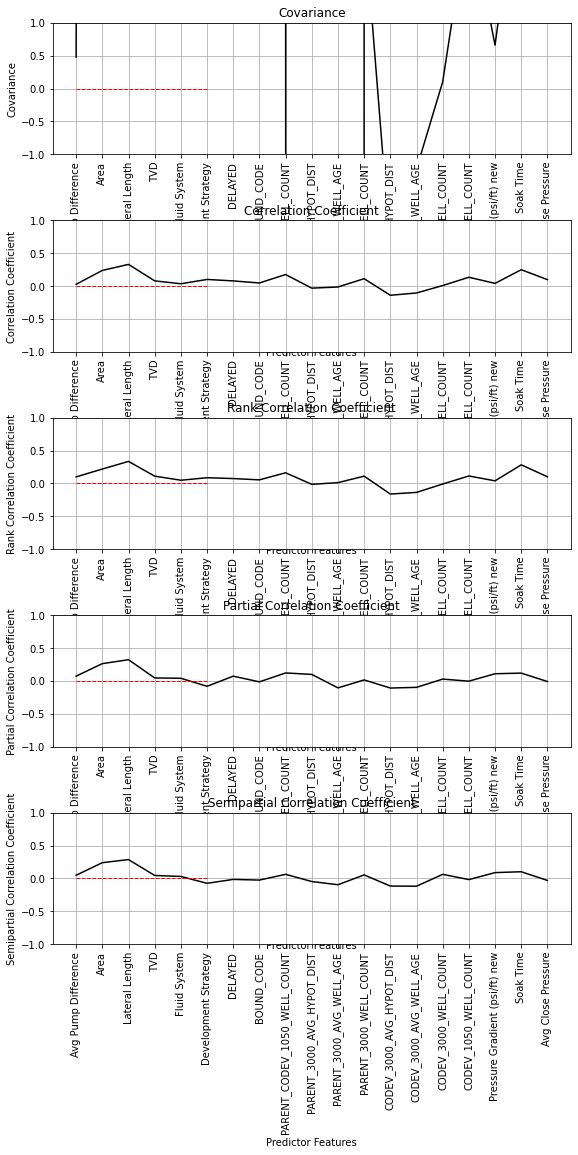

In [22]:
features = df_norm.columns.values[1:]
plt.subplot(511)
plt.plot(features,stand_covariance,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)
plt.xticks(rotation=90)

plt.subplot(512)
plt.plot(features,stand_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',linewidth = 1.0)
plt.xlabel('Predictor Features', )
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)
plt.xticks(rotation=90)

plt.subplot(513)
plt.plot(features,stand_rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',linewidth = 1.0)
plt.xlabel('Predictor Features',)
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)
plt.xticks(rotation=90)

plt.subplot(514)
plt.plot(features,stand_partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',linewidth = 1.0)
plt.xlabel('Predictor Features', )
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)
plt.xticks(rotation=90)

plt.subplot(515)
plt.plot(features,stand_semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',linewidth = 1.0)
plt.xlabel('Predictor Features', )
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)
plt.xticks(rotation=90)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=3.2, wspace=0.3, hspace=0.5)
plt.show()

#### model-based importance

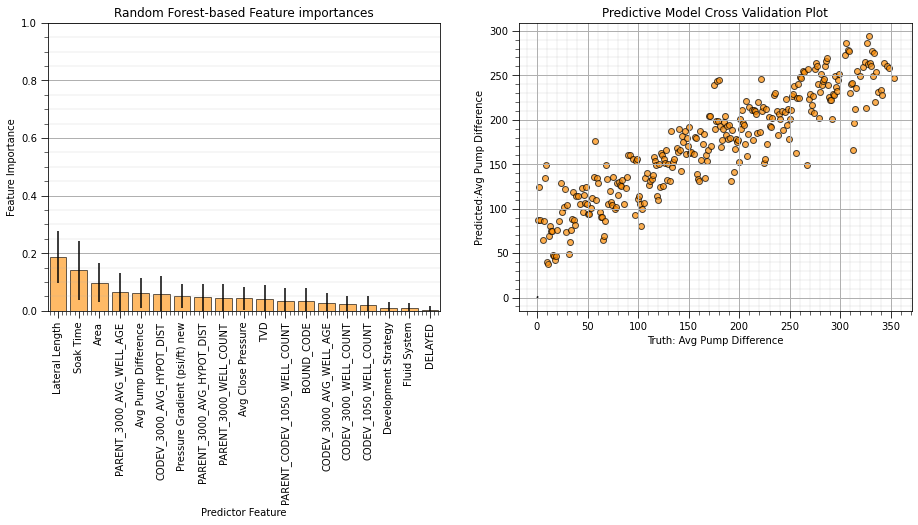

In [24]:
x = df_norm.iloc[:,1:]
Y = df_norm.iloc[:,0]

seed = 73093                                                # set the random forest hyperparameters
max_depth = 7
min_samples_leaf = 5
num_tree = 500
max_features = 6
random_forest = RandomForestRegressor(min_samples_leaf = min_samples_leaf,random_state=seed,n_estimators=num_tree, max_features=max_features)
random_forest.fit(x,Y) # fit the random forest
y_hat = random_forest.predict(x)

importance_rank = random_forest.feature_importances_ # extract the expected feature importances
importance_rank_stand = importance_rank/np.max(importance_rank)                          # calculate relative mutual information

std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importance_rank)[::-1]             # find indicies for descending order

plt.subplot(121)                                        # plot the feature importance 
plt.title("Random Forest-based Feature importances")
plt.bar(range(x.shape[1]), importance_rank[indices],edgecolor = 'black',
       color="darkorange",alpha = 0.6, yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.ylim([0.,1.0])
plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')

plt.subplot(122)                                         # model cross validation plot
plt.scatter(Y,y_hat,color='darkorange',edgecolor='black',alpha=0.7)
plt.grid(visible=True,which='both',axis='both')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5)); plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().xaxis.grid(True, which='major',linewidth = 1.0); plt.gca().xaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
#plt.xlim([Ymin,Ymax]); plt.ylim([Ymin,Ymax]); 
plt.xlabel('Truth: ' + 'Avg Pump Difference'); plt.ylabel('Predicted:' + 'Avg Pump Difference')
plt.plot([-0.2,1.2],[-0.2,1.2],color='black',ls='--'); 
plt.title('Predictive Model Cross Validation Plot')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5); plt.show()

#### mutual information

Feature ranking:
1. feature Area = 1.000000
2. feature Lateral Length = 0.690989
3. feature PARENT_3000_WELL_COUNT = 0.670825
4. feature TVD = 0.665586
5. feature PARENT_CODEV_1050_WELL_COUNT = 0.588399
6. feature PARENT_3000_AVG_HYPOT_DIST = 0.575348
7. feature PARENT_3000_AVG_WELL_AGE = 0.525165
8. feature CODEV_3000_AVG_HYPOT_DIST = 0.460349
9. feature CODEV_3000_WELL_COUNT = 0.433690
10. feature CODEV_1050_WELL_COUNT = 0.410432
11. feature CODEV_3000_AVG_WELL_AGE = 0.392239
12. feature Pressure Gradient (psi/ft) new = 0.382658
13. feature Development Strategy = 0.346283
14. feature Fluid System = 0.282046
15. feature BOUND_CODE = 0.265190
16. feature DELAYED = 0.183664
17. feature Avg Close Pressure = 0.094889
18. feature Avg Pump Difference = 0.080836
19. feature Soak Time = 0.063461


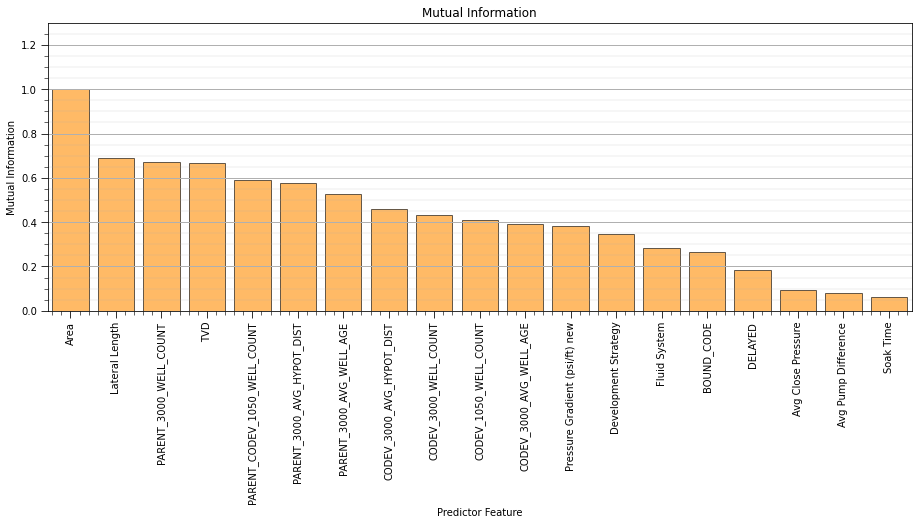

In [25]:
x = df_norm.iloc[:,1:]
y = df_norm.iloc[:,0]

mi = mutual_info_regression(x,np.ravel(y))              # calculate mutual information
mi /= np.max(mi)                                        # calculate relative mutual information

mi_orig = mi

indices = np.argsort(mi)[::-1]                          # find indicies for descending order

print("Feature ranking:")                               # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi[indices[f]]))

plt.subplot(111)                                        # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],edgecolor = 'black',
       color="darkorange",alpha=0.6,align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); plt.ylim([0,1.3])
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.xlabel('Predictor Feature'); plt.ylabel('Mutual Information')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5)
plt.show()

### Model Building: training + k-fold cross validation

In [48]:
newdf4

,Well ID,Avg Pump Difference,Area,Lateral Length,TVD,Fluid System,Development Strategy,DELAYED,BOUND_CODE,PARENT_CODEV_1050_WELL_COUNT,PARENT_3000_AVG_HYPOT_DIST,PARENT_3000_AVG_WELL_AGE,PARENT_3000_WELL_COUNT,CODEV_3000_AVG_HYPOT_DIST,CODEV_3000_AVG_WELL_AGE,CODEV_3000_WELL_COUNT,CODEV_1050_WELL_COUNT,Pressure Gradient (psi/ft) new,Soak Time,Avg Close Pressure
0,1,-0.93,0,10300,10415.0,0,0,1,11100000,2,2071.0,1840.0,12,1490,0.0,1,0,0.593758,34,2719.898438
1,2,-8.45,0,10300,10415.0,0,0,1,11100000,2,2071.0,1840.0,12,1490,0.0,1,0,0.597059,67,2934.885325
2,3,8.70,1,11000,8470.0,0,3,0,101111,6,2492.0,2397.0,6,1165,4.5,11,6,0.516873,34,1589.948673
3,4,NaN,1,11000,10555.0,0,0,1,11110000,1,2378.0,2416.0,20,1000,0.0,1,1,0.501287,30,1304.162878
5,6,-4.34,3,12300,10355.0,0,0,1,11110000,0,2464.0,3454.0,13,2077,21.5,4,0,0.565200,21,2063.408619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,343,75.63,12,15700,9480.0,2,3,1,11011111,5,2144.0,916.0,40,1072,1.2,5,3,0.495240,59,2088.177345
336,345,NaN,0,10200,8160.0,0,0,1,10001000,2,1870.0,790.0,7,1601,5.0,4,1,0.617175,376,2598.995714
337,346,5.99,10,18200,8335.0,1,2,0,10001001,2,2678.0,732.0,4,1556,7.1,7,2,0.541321,815,2844.170027
339,348,5.38,10,18200,8335.0,1,2,0,10001001,2,2678.0,732.0,4,1556,7.1,7,2,0.541567,988,2958.170289


In [74]:
newdf4.head()

,Well ID,Avg Pump Difference,Area,Lateral Length,TVD,Fluid System,Development Strategy,DELAYED,BOUND_CODE,PARENT_CODEV_1050_WELL_COUNT,PARENT_3000_AVG_HYPOT_DIST,PARENT_3000_AVG_WELL_AGE,PARENT_3000_WELL_COUNT,CODEV_3000_AVG_HYPOT_DIST,CODEV_3000_AVG_WELL_AGE,CODEV_3000_WELL_COUNT,CODEV_1050_WELL_COUNT,Pressure Gradient (psi/ft) new,Soak Time,Avg Close Pressure
0,1,-0.93,0,10300,10415.0,0,0,1,11100000,2,2071.0,1840.0,12,1490,0.0,1,0,0.593758,34,2719.898438
1,2,-8.45,0,10300,10415.0,0,0,1,11100000,2,2071.0,1840.0,12,1490,0.0,1,0,0.597059,67,2934.885325
2,3,8.70,1,11000,8470.0,0,3,0,101111,6,2492.0,2397.0,6,1165,4.5,11,6,0.516873,34,1589.948673
5,6,-4.34,3,12300,10355.0,0,0,1,11110000,0,2464.0,3454.0,13,2077,21.5,4,0,0.565200,21,2063.408619
6,7,0.54,3,12600,8120.0,0,3,1,10101111,4,1570.0,3561.0,12,694,-0.7,3,2,0.561294,34,2330.939138


In [75]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

x = newdf4[['Pressure Gradient (psi/ft) new','Fluid System','Avg Close Pressure','Lateral Length','Area','PARENT_3000_WELL_COUNT']]
y = newdf4[['Avg Pump Difference']]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


param_grid = {
    'n_estimators': [200,300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [1,2],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}


# Create the RandomForestRegressor model with preprocessor
model = RandomForestRegressor(random_state=55)

# Choose GridSearchCV or RandomizedSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print(f'Best Hyperparameters: {best_params}')

# Use the best model for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Best Model): {mse}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-packages\

Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mean Squared Error (Best Model): 245.83708069626098


0.8582430831003536

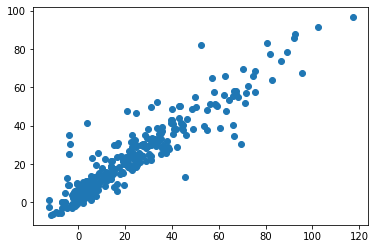

In [78]:
plt.scatter(y,best_model.predict(x))
r2_score(y,best_model.predict(x))

In [80]:
THEtest = testing.drop(['Well ID'],axis=1)

### Prediction & Uncertainty

In [84]:
# prediction 

test_x = testing[['Pressure Gradient (psi/ft) new','Fluid System','Avg Close Pressure','Lateral Length','Area','PARENT_3000_WELL_COUNT']]

predictions = best_model.predict(test_x)

print(predictions)

[ 3.07252000e+01  3.79121000e+01 -5.62666667e-02  6.60121333e+01
  8.66403333e+00  1.55065667e+01  1.27924000e+01 -2.68183333e+00
  5.62461000e+01  5.31170000e+00  1.99577667e+01  3.65310667e+01
  2.39403333e+00 -8.76766667e-01]


In [85]:
from sklearn.ensemble import RandomForestRegressor
import random


x = newdf4[['Pressure Gradient (psi/ft) new','Fluid System','Avg Close Pressure','Lateral Length','Area','PARENT_3000_WELL_COUNT']]
y = newdf4[['Avg Pump Difference']]

A= []
for a in np.arange(0,100):
    # Define the RandomForestRegressor with specified hyperparameters
    rf_model = RandomForestRegressor(
        bootstrap=True, 
        max_depth=20, 
        min_samples_leaf=1, 
        min_samples_split=2,  # Set to 2 as the minimum required
        n_estimators=1,
        random_state=random.randint(0,10000)  # for reproducibility
    )

    # Fit the model on your data
    rf_model.fit(x, y)
    
    A.append(rf_model.predict(test_x))
# Now the model is ready to make predictions or be evaluated

C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\3238292308.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x, y)
C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\3238292308.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x, y)
C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\3238292308.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x, y)
C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\3238292308.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x, y)


C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\3238292308.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x, y)
C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\3238292308.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x, y)
C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\3238292308.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x, y)
C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\3238292308.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x, y)


C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\3238292308.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x, y)
C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\3238292308.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x, y)
C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\3238292308.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x, y)
C:\Users\Mohamed Awad\AppData\Local\Temp\ipykernel_3656\3238292308.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x, y)


Uncertainty results

In [86]:
A

[array([ 28.1 ,  33.77,   2.5 , 102.51,  -0.46,   6.34,   7.44,   4.26,
         58.05,  -9.64,  65.88,  25.29,  -8.45,  -2.47]),
 array([ 72.63,  33.77,   2.5 , 102.51,  19.2 ,  28.3 ,   5.25,  -2.47,
         62.34,   8.31,  22.47,  21.04,   0.85,  -2.47]),
 array([ 8.7 , 24.65, -3.13, 57.13, -0.13,  6.17,  5.14,  4.26, 30.86,
        -9.64, 19.15, 11.31,  4.26, -2.47]),
 array([ 66.52,  40.1 , -12.69,  92.25,  -0.46,   6.17,   5.25,  -6.8 ,
         59.23,  37.  ,  66.63,  64.22,   0.88,  -0.78]),
 array([66.52, 40.1 ,  0.37, 57.13, -0.46,  6.17, 20.  , -4.9 , 62.34,
         8.31, 22.48, 20.93,  1.51, -0.78]),
 array([30.18, 86.53, -3.13, 57.13, -0.46, 26.68, 22.28, -2.68, 20.89,
        22.28, 10.28, 26.09,  0.88,  1.84]),
 array([65.98, 43.38,  0.1 , 57.13, -0.13, 12.63, 45.82, -2.47, 20.89,
         6.73,  2.1 , 44.56,  0.85, -2.47]),
 array([ 34.34,  40.1 ,  -2.68, 117.26,  -1.7 ,  12.63,  -0.71,  -2.47,
         62.34,   8.31,   2.1 ,  44.26,   1.58,  -2.47]),
 array([20.93, 2